# Feature Transformations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

## Learning Objectives

- Use correlations and other algorithms to inform feature selection
- Create new features for use in modeling
    - Use binning to turn numerical into categorical features
    - Use `PolynomialFeatures` to build compound features

## Model Selection

Let's imagine that I'm going to try to predict wine quality based on the other features.

In [2]:
wine = pd.read_csv('data/wine.csv')

In [3]:
wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,1
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,1
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,1


## Decisions, Decisions, Decisions...

Now: Which columns (predictors) should I choose? 

There are 12 predictors I could choose from. For each of these predictors, I could either use it or not use it in my model, which means that there are $2^{12} = 4096$ _different_ models I could construct! Well, okay, one of these is the "empty model" with no predictors in it. But there are still 4095 models from which I can choose.

How can I decide which predictors to use in my model?

We'll explore a few methods in the sections below.

## Correlation

Our first attempt might be just see which features are _correlated_ with the target to make a prediction.

We can use the correlation metric in making a decision.

In [4]:
# Use the .corr() DataFrame method to find out about the
# correlation values between all pairs of variables!

None

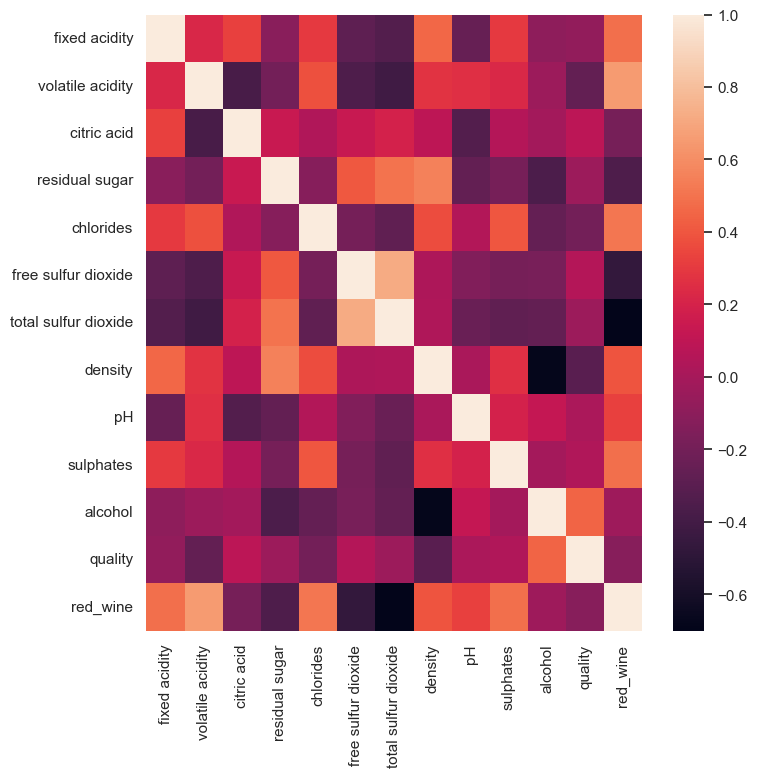

In [5]:
sns.set(rc={'figure.figsize':(8, 8)})

# Use the .heatmap function to depict the relationships visually!
sns.heatmap(wine.corr());

In [6]:
# Let's look at the correlations with 'quality'
# (our dependent variable) in particular.

wine_corrs = wine.corr()['quality'].map(abs).sort_values(ascending=False)
wine_corrs

quality                 1.000000
alcohol                 0.444319
density                 0.305858
volatile acidity        0.265699
chlorides               0.200666
red_wine                0.119323
citric acid             0.085532
fixed acidity           0.076743
free sulfur dioxide     0.055463
total sulfur dioxide    0.041385
sulphates               0.038485
residual sugar          0.036980
pH                      0.019506
Name: quality, dtype: float64

It looks like we can see the features have different correlations with the target. The larger the correlation, the more we'd expect these features to be better predictors.

Let's try using only a subset of the strongest correlated features to make our model.

In [15]:
# wine.corr()["quality"].sort_values().loc[lambda x: x > 0]

# aggiunto da me

In [ ]:
# Let's choose 'alcohol' and 'density'.

wine_preds = wine[['alcohol', 'density']]
wine_target = wine['quality']
preds_with_const = sm.add_constant(wine_preds)

In [ ]:
model = sm.OLS(endog=wine_target, exog=preds_with_const).fit()

In [ ]:
model.rsquared

## Feature Engineering

> Domain knowledge can be helpful here! 🧠

In practice this aspect of data preparation can constitute a huge part of the data scientist's work. As we move into data modeling, much of the goal will be a matter of finding––**or creating**––features that are predictive of the targets we are trying to model.

There are infinitely many ways of transforming and combining a starting set of features. Good data scientists will have a nose for which engineering operations will be likely to yield fruit and for which operations won't. And part of the game here may be getting someone else on your team who understands what the data represent better than you!

Let's try this ourselves! Since I don't know much about wine, I'm really just guessing.

In [ ]:
wine.head(10)

## Distribution Transformations

### Log Scaling

Linear regression can work better if the predictor and target are normally distributed. 

**Log-scaling** can be a good tool to make *right-skewed* data more normal.

(For *left-skewed* data, which is rarer, we can try transforming our data by raising it to an exponent greater than 1.)

Suppose e.g. a kde plot of my predictor $X$ looks like this:

![original](images/skewplot.png)

In that case, the kde plot of a log-transformed version of $X$ could look like this:

![log](images/logplot.png)

Let's set up a problem like this.

In [ ]:
diamonds = sns.load_dataset('diamonds')

In [ ]:
X = diamonds.select_dtypes(include=float)
y = diamonds['price']

### Build model

In [ ]:
sm.OLS(endog=y, exog=X).fit().summary()

### Check distribution of target

In [ ]:
y.hist();

In [ ]:
y_scld = np.log(y)
y_scld.hist();

### Build model with log-scaled target

In [ ]:
model_diam = sm.OLS(y_scld, X).fit()
model_diam.summary()

### Interpreting Log-Transformed Coefficients

But with this transformed target, how do I now interpret my LR coefficients?

Before the transformation, I would have said that a one-unit increase in, say, depth results on average in a 0.0319 increase in price. But what I need to say now is that a one-unit increase in depth results on average in a 0.0319 increase *in the logarithm of price*, i.e. an increase in price by a factor of $e^{0.0319}$.

In [ ]:
print(f"""
A one-unit increase in the depth variable corresponds
to an increase in price by a factor of {round(np.exp(0.0319), 3)},
or {100 * round(np.exp(0.0319) - 1, 3)}%.
""")

For more on this, including how to interpret coefficients after log-transforming *independent* variables, check out [this resource](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/).

## Binning

To start we'll look at some `seaborn` Pair Plots. We'll do this in two halves so that we can see things a bit more clearly:

In [ ]:
# This will show the first six predictors and 'quality'
columns = [True if j < 6 or j == 11 else False for j in range(13)]

sns.pairplot(data=wine.iloc[:, columns]);

In [ ]:
sns.pairplot(data=wine.iloc[:, 6:]);

### Volatile Acidity

Let's look at the distribution of the volatile acidity feature:

In [ ]:
wine['volatile acidity'].hist();

Suppose we add more bins:

In [ ]:
wine['volatile acidity'].hist(bins=50);

Now the distribution looks quite different. There seems to be a small second peak around 0.6. And we can reproduce this if we check out `seaborn`'s kernel density plot.

In [ ]:
sns.kdeplot(wine['volatile acidity']);

So suppose we build a new feature that records whether a wine's volatile acidity is above 0.5.

In [ ]:
wine['high_va'] = wine['volatile acidity'] > 0.5

In [ ]:
# Now we can build a new model with this feature.

wine_preds2 = wine[['alcohol', 'density', 'high_va']]

In [ ]:
lr2 = LinearRegression().fit(wine_preds2, wine_target)

In [ ]:
lr2.score(wine_preds2, wine_target)

Not bad! We don't seem to have stumbled onto a huge connection here, but this correlation value suggests that this new feature may be helpful in a final model.

### $\bf{SO_2}$

Next we'll take a look at distribution of the sulfur dioxide feature:

In [ ]:
wine['total sulfur dioxide'].hist(bins=35);

Let's try separating our wines into those with sulfur dioxide higher than 80 and those with less:

In [ ]:
wine['high_so2'] = wine['total sulfur dioxide'] > 80

In [ ]:
wine.corr()['quality']['high_so2']

Not great. Perhaps this is a modeling dead end.

## Products of Features

Another engineering strategy we might try is **multiplying features together**.

Let's try these two features: `residual sugar` and `total sulfur dioxide`. Note that without domain knowledge or exploration, this is really a guess that this combination will predict `quality` well.

In [ ]:
wine['rs*tsd'] = wine['residual sugar'] * wine['total sulfur dioxide']

In [ ]:
wine.corr()['quality']['rs*tsd']

In [ ]:
wine.corr()['quality']['residual sugar']

In [ ]:
wine.corr()['quality']['total sulfur dioxide']

We can see these two features together have a higher correlation than each by itself!

## Polynomial Features

Instead of just multiplying features at random, we might consider trying **every possible product of features**. That's what PolynomialFeatures does:

In [ ]:
pf = PolynomialFeatures(degree=3)

X = wine.drop('quality', axis=1)
y = wine['quality']

# Fitting the PolynomialFeatures object
pf.fit(X)

In [ ]:
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf

In [ ]:
pdf.shape

In [ ]:
lr = LinearRegression()

lr.fit(pdf, y)

In [ ]:
lr.score(pdf, y)

So: Is this a good idea? What are the potential dangers here?

## Exercise

Consider the following dataset:

In [ ]:
sales = pd.read_csv('data/Advertising.csv', index_col=0)

sales.head()

We'd like to try to understand sales as a function of spending on various media (TV, radio, newspaper).

In [ ]:
sales.corr()['sales']

**Try to find the best multiplicative combination of features.**

You may use `PolynomialFeatures` or just multiply by hand.

In practice, it's not easy to tell when such products of features will be so fruitful. Moreover, there is room for concern about violating regression's demand for feature independence. At the very least, we would probably not want to include a product *and the individual features themselves* in a final model, not if our goal is to understand what's really responsible for fluctuations in our target variable.